In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_model_summary import summary
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import cv2
from ignite.metrics import PSNR, SSIM
from sim import heatmap

### Dataset

In [2]:
train_file_path = 'data/trainset.npy' # 2100장
val_file_path = 'data/validset.npy' # 300장
test_file_path = 'data/testset.npy' # 600장

Load dataset

In [3]:
loaded = np.load(test_file_path, allow_pickle=True)

In [4]:
data = loaded.tolist()
d = dict(data)
print(d.keys())

dict_keys(['f_nd', 'f_qd'])


In [10]:
print(d['f_nd'].shape)
print(d['f_qd'].shape)

nd = d['f_nd']  # 일반 선량 -> 높은 선량의 방사선을 사용하여 얻은 이미지, 이미지의 대비가 높고 상세하게 나타남 (normal)
qd = d['f_qd']  # 1/4 선량 -> 낮은 선량의 방사선을 사용하여 얻은 이미지, 이미지의 대비가 낮고, 세부 정보가 덜 표현됨 (noise)

H = nd.shape[0]
W = nd.shape[1]
length = nd.shape[2]

print(np.min(nd), np.max(nd))

(512, 512, 600)
(512, 512, 600)
-0.0004608007 0.0770496


HU 

In [11]:
def HU(z, u_water=0.0192):
    return (z - u_water) * 1000 / u_water

ndct = HU(d['f_nd'])
qdct = HU(d['f_qd'])

print(np.min(ndct), np.max(ndct))

-1024.0 3012.9998


Sampling

(-0.5, 511.5, 511.5, -0.5)

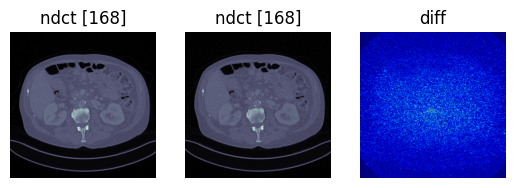

In [7]:
r = np.random.randint(0, length)

# ndct
plt.subplot(1,3,1)
ndct_sample = ndct[:,:,r ]
plt.imshow(ndct_sample, cmap='bone')
plt.title(f"ndct [{r}]")
plt.axis('off')

# qdct
plt.subplot(1,3,2)
qdct_sample = qdct[:,:,r ]
plt.imshow(qdct_sample, cmap='bone')
plt.title(f"ndct [{r}]")
plt.axis('off')

# diff
plt.subplot(1,3,3)
hmap = heatmap(torch.from_numpy(ndct_sample), torch.from_numpy(qdct_sample))
plt.imshow(hmap, cmap='bone')
plt.title(f"diff")
plt.axis('off')

PSNR

In [8]:
def psnr_error(x, y):
    if x.dim() == 2:
        h, w  = x.shape[0], x.shape[1]
        x = x.view(1,1,h,w)
        y = y.view(1,1,h,w)
    elif x.dim() == 3:
        x = x.unsqueeze(0)
        y = y.unsqueeze(0)
    psnr_metric = PSNR(data_range=torch.max(x))
    psnr_metric.update((x, y))
    return psnr_metric.compute()

psnr = psnr_error(torch.from_numpy(ndct_sample), torch.from_numpy(qdct_sample))
print('psnr:', psnr)

psnr: 31.599647723805813


SSIM

In [9]:
def ssim_error(x, y):
    if x.dim() == 2:
        h, w  = x.shape[0], x.shape[1]
        x = x.view(1,1,h,w)
        y = y.view(1,1,h,w)
    elif x.dim() == 3:
        x = x.unsqueeze(0)
        y = y.unsqueeze(0)
    ssim_metric = SSIM(data_range=torch.max(x))
    ssim_metric.update((x, y))
    return ssim_metric.compute()

ssim = ssim_error(torch.from_numpy(ndct_sample), torch.from_numpy(qdct_sample))
print('ssim:', ssim)

ssim: 0.7459428800844302


Normalize

In [25]:
def normalize(x, mu=-500, sigma=500):
    x = (x-mu)/sigma
    return x

print(np.min(ndct_sample), np.max(ndct_sample))
n_ndct_sample = normalize(ndct_sample)
print(np.min(n_ndct_sample), np.max(n_ndct_sample))

-1024.0 1751.0
-1.048 4.502


Denormalize

In [26]:
def denormalize(x, mu=-500, sigma=500):
    x = x*sigma+mu
    return x

d_ndct_sample = denormalize(n_ndct_sample)
print(np.min(d_ndct_sample), np.max(d_ndct_sample))

-1024.0 1751.0
